# Chicago Crime (2008-2012) - Visualisations 

As a part of my AI and machine learning program, I just finished a course in data proccessing. During the course I got to work with Python modules such as Pandas, Seaborn, and Plotly express. 

For the last assignment, I analysed crime data from Chicago to answer various questions. 

**Note:** This is only a select portion of the assignment, and not the entire project (i.e. not all questions are included). In this notebook, I specifically want to showcase the data visualisation work I've done. 😁




◆ **Data Sources:**

Chicago crime data : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

Chicago census data : https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2

Chicago community areas GeoJSON: https://data.cityofchicago.org/resource/igwz-8jzy.geojson

----



In [ ]:
# -------------------------------------------
# 🔹 IMPORTS
# -------------------------------------------
import pandas as pd
import seaborn as sns
import plotly_express as px 

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Map plotting
import geopandas as gpd 
import folium 
from folium.plugins import HeatMap, MarkerCluster


import warnings
warnings.filterwarnings('ignore')

In [2]:
# -------------------------------------------
# 🔹 LOAD DATA
# -------------------------------------------
chicago_crime_2001_to_2025_df = pd.read_csv('chicago_crime.csv')
chicago_census_2008_to_2012_df = pd.read_csv('chicago_census.csv')

In [3]:
# -------------------------------------------
# 🔹 FITER CRIME DATAFRAME
# -------------------------------------------
# Convert 'Date' column to datetime format
chicago_crime_2001_to_2025_df['Date'] = pd.to_datetime(chicago_crime_2001_to_2025_df['Date'], format='%m/%d/%Y %I:%M:%S %p')
# NOTE: Pandas displays datetime object using default display format YYYY-mm-dd HH:MM:SS


# Create a new dataframe with crime records from the period 2008-2008
year_2008_to_2012_filter = chicago_crime_2001_to_2025_df['Date'].dt.year.between(2008, 2012)

chicago_crime_2008_to_2012_df = chicago_crime_2001_to_2025_df[year_2008_to_2012_filter].reset_index(drop=True)


# Create some new columns (Year, Month, Day, and Hour)
chicago_crime_2008_to_2012_df['Year'] = chicago_crime_2008_to_2012_df['Date'].dt.year
# 'Year' column already exists, this only changes the dtype to "int32", which is more memory-efficient than "int64"

chicago_crime_2008_to_2012_df['Month'] = chicago_crime_2008_to_2012_df['Date'].dt.month_name()

chicago_crime_2008_to_2012_df['Weekday'] = chicago_crime_2008_to_2012_df['Date'].dt.day_name()  

chicago_crime_2008_to_2012_df['Hour'] = chicago_crime_2008_to_2012_df['Date'].dt.hour


-----

## Crime Overview per Year

The total number of crimes recorded during the period 2008-2012 is 1879047
   Year  Crime Count
0  2008       427212
1  2009       392862
2  2010       370561
3  2011       352045
4  2012       336367


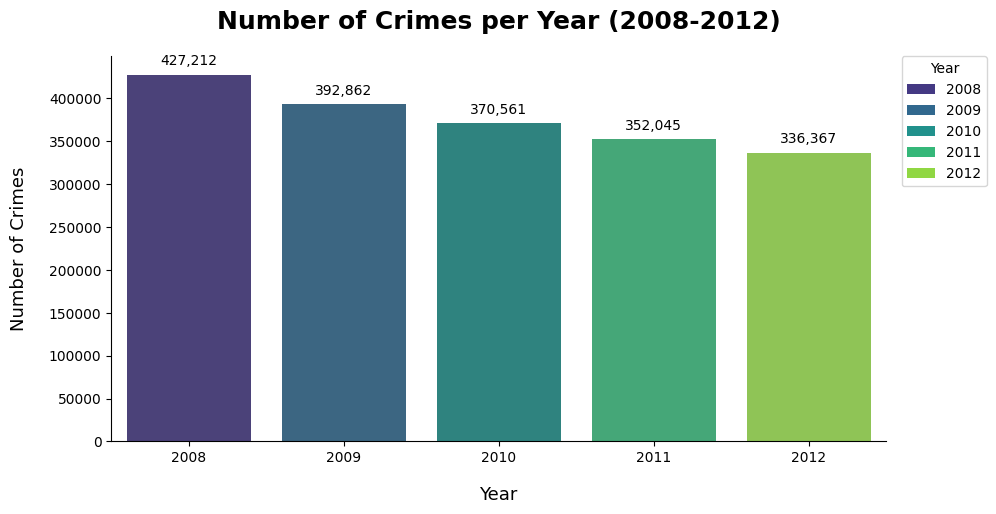

In [ ]:
# -------------------------------------------
# 🔹 A LOOK AT CRIMES PER YEAR 
# -------------------------------------------
print(f'The total number of crimes recorded during the period 2008-2012 is {chicago_crime_2008_to_2012_df.shape[0]}')

# Data prepping
crimes_per_year_df = chicago_crime_2008_to_2012_df['Date'].dt.year.value_counts().sort_index().reset_index()

crimes_per_year_df.columns = ['Year', 'Crime Count'] 
print(crimes_per_year_df)   # prints the years and the total number of crimes recorded for each year


# -------------------------------------------
# 🔹 PLOT: CRIMES PER YEAR (2008-2012) 
# -------------------------------------------
palette = sns.color_palette('viridis', len(crimes_per_year_df))

plt.figure(figsize=(10, 5))

bars = sns.barplot(x='Year', 
                   y='Crime Count', 
                   data=crimes_per_year_df, 
                   palette=palette)

# Add counts above the bars
for bar, count in zip(bars.patches, crimes_per_year_df['Crime Count']):
    bars.annotate(
        '{:,}'.format(count),   # formatting the numbers with commas
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 5),          # vertical offset
        textcoords='offset points',
        ha='center',
        va='bottom')

# Legend plot
legend_handles = [Patch(facecolor=palette[i], label=str(year))
                  for i, year in enumerate(crimes_per_year_df['Year'])]

plt.legend(handles=legend_handles, 
           title='Year', 
           loc='upper left', 
           bbox_to_anchor=(1.02, 1), 
           borderaxespad=0)

# Style improvements
plt.title('Number of Crimes per Year (2008-2012)', size=18, pad=20, fontweight='bold')
plt.ylabel('Number of Crimes', size=13, labelpad=15)
plt.xlabel('Year', size=13, labelpad=15)

# Remove the top and right frame lines / spines
sns.despine(top=True, right=True) 

plt.show()

In [ ]:
# -------------------------------------------
# 🔹 CRIME RATES 2008 VS. 2012
# -------------------------------------------
# I noticed that there are two "Criminal sexual assault" types (just spelled differently), 
# so I replaced the name of one of them (which added the two amounts of reported crimes into one category)
chicago_crime_2008_to_2012_df['Primary Type'] = (
    chicago_crime_2008_to_2012_df['Primary Type']
    .replace('CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT')
)

crime_counts_2008_and_2012_df = (
    chicago_crime_2008_to_2012_df           
    [chicago_crime_2008_to_2012_df['Year'].isin([2008, 2012])]   # Filer years
    .groupby(['Primary Type', 'Year'])                           # Group by crime and by year
    .size()                                                      # Count occurances 
    .unstack(fill_value=0)                                       # Pivot years into columns
    .rename_axis(columns=None)                                   # Remove MultiIndex column name
    .reset_index()                                               # Make 'Primary Type' a column
)

# Calculate absolute and procent change
crime_counts_2008_and_2012_df['Change'] = (crime_counts_2008_and_2012_df[2012] - crime_counts_2008_and_2012_df[2008])
crime_counts_2008_and_2012_df['Percent Change'] = ((crime_counts_2008_and_2012_df['Change'] / crime_counts_2008_and_2012_df[2008]) * 100).round(2)

pd.set_option('display.max_rows', None)
print(crime_counts_2008_and_2012_df)

                        Primary Type   2008   2012  Change  Percent Change
0                              ARSON    644    469    -175          -27.17
1                            ASSAULT  25448  19900   -5548          -21.80
2                            BATTERY  75930  59132  -16798          -22.12
3                           BURGLARY  26218  22844   -3374          -12.87
4                    CRIMINAL DAMAGE  52843  35855  -16988          -32.15
5            CRIMINAL SEXUAL ASSAULT   1566   1469     -97           -6.19
6                  CRIMINAL TRESPASS  12310   8216   -4094          -33.26
7                 DECEPTIVE PRACTICE  14942  13788   -1154           -7.72
8                           GAMBLING   1199    724    -475          -39.62
9                           HOMICIDE    513    515       2            0.39
10  INTERFERENCE WITH PUBLIC OFFICER    580   1228     648          111.72
11                      INTIMIDATION    261    156    -105          -40.23
12                       

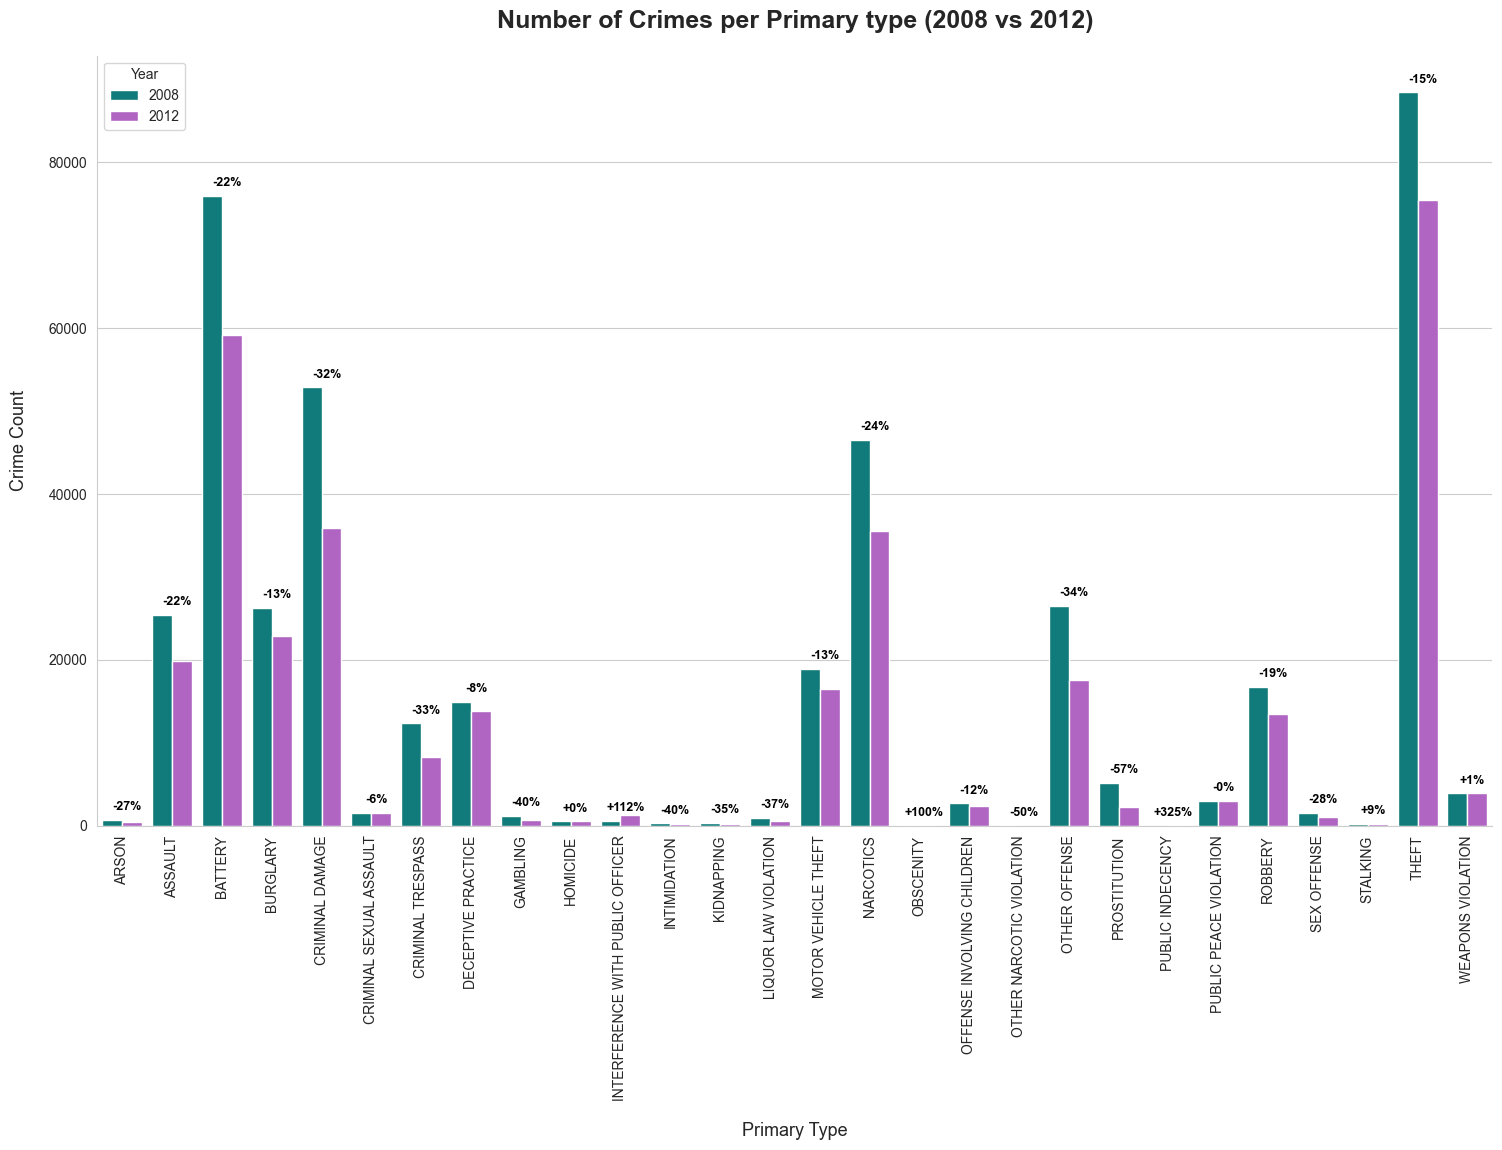

In [ ]:
# -------------------------------------------
# 🔹 PLOT: NUMBER OF CRIMES 2008 VS. 2012 
# -------------------------------------------
# Melt the DataFrame to have 'Year' as a variable
crime_counts_2008_and_2012_melted = crime_counts_2008_and_2012_df.melt(
    id_vars='Primary Type',         # column is kept as-is
    value_vars=[2008, 2012],        # columns melt into rows
    var_name='Year',                # new column name for the original column headers (Year)
    value_name='Crime Count'        # new column name for the values
)

plt.figure(figsize=(18,10))

sns.set_style('whitegrid')

# Grouped bar plot (using hue)
bars = sns.barplot(
    x='Primary Type',
    y='Crime Count',
    hue='Year',
    data=crime_counts_2008_and_2012_melted,
    palette=['darkcyan', 'mediumorchid']        # different color for each year
)

for i, primary_type in enumerate(crime_counts_2008_and_2012_df['Primary Type']):
    count_2008 = crime_counts_2008_and_2012_df.loc[i, 2008]
    count_2012 = crime_counts_2008_and_2012_df.loc[i, 2012]
    percent_change = crime_counts_2008_and_2012_df.loc[i, 'Percent Change']

    # x-position is the center of the 2012 bar (ish)
    bars.annotate(
        f'{percent_change:+.0f}%',      # show + or  - sign, and only one decimal
        xy=(i + 0.1, count_2008),       # 0.1 offset to match Seaborn hue placement 
        xytext=(0, 5),                  # offset above the bar
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='black'
    )

# Remove top and right spines
sns.despine(top=True, right=True)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Style improvements
plt.title('Number of Crimes per Primary type (2008 vs 2012)', size=18, pad=20, fontweight='bold')
plt.ylabel('Crime Count', size=13, labelpad=15)
plt.xlabel('Primary Type', size=13, labelpad=15)

plt.legend(title='Year')
plt.show()

**Recommendation: View the plot on a full screen!**

**Comments on the plot**

So the plot above definitely isn't perfect, primarily because the bars for some crimes are barely visible. I was thinking about changing it, for example, by making two versions of the plot: one with the more frequent crimes and one with the less frequent ones. However, I feel like that could have invited another problem: mainly that the plot for the less frequent crimes would, of course, scale up and when looking at the two plots next to each other, it could appear as if the less frequent crimes are more "common" than they actually are. 

While the plot above definitely has flaws, I would say that it provides some perspective to the viewer. You're not only seeing a representation of recorded crimes and whether they have increased/decreased/stayed the same; you also get a sense of how "uncommon" certain crimes are compared to others. 

I'm aware it's **not** the best plot, but it does give you an overview, so I decided to keep it. 

---

## Chicago Police Department Preformance Assesment

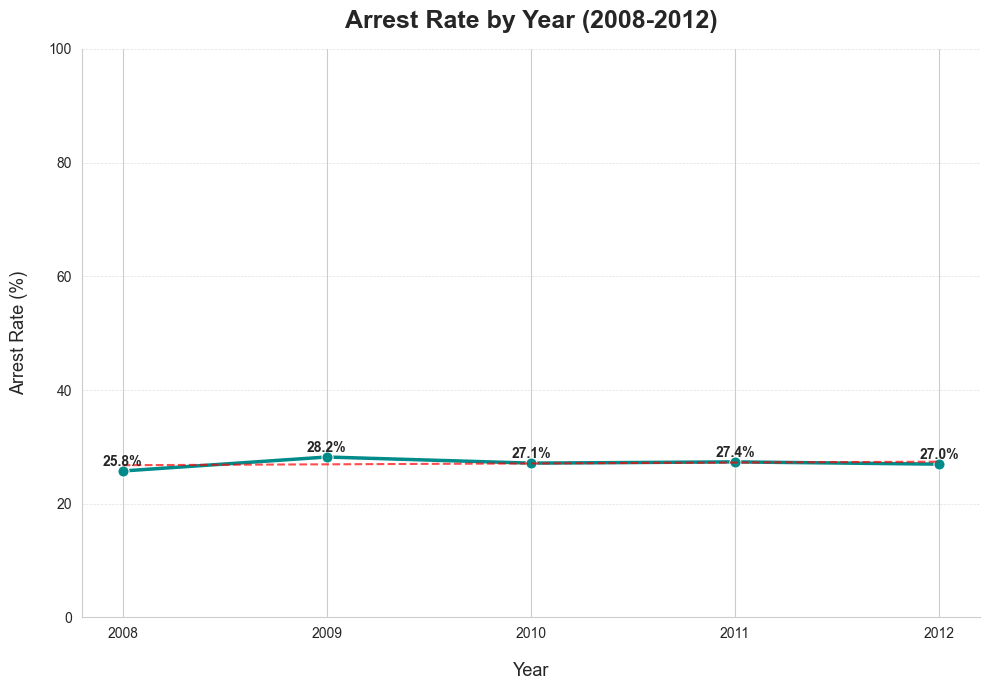

In [12]:
# -------------------------------------------
# 🔹 ARREST RATE PER YEAR (PLOT)
# -------------------------------------------
# Calculate arrest rate per year
arrest_rates_by_year = (
    chicago_crime_2008_to_2012_df
    .groupby('Year')['Arrest']      # splits the data by each year
    .mean()*100                     # calculated the proportion of True values in each group (and converts to percentage)
).reset_index()

# Extract x & y for trendlines
x = arrest_rates_by_year['Year']
y = arrest_rates_by_year['Arrest']

# Calculating linear trendline (using polyfit)
slope, intercept = np.polyfit(x, y, 1)
trendline_y = slope * x + intercept

# Main plot
plt.figure(figsize=(10,7))
sns.lineplot(
    data=arrest_rates_by_year,
    x='Year',
    y='Arrest',
    marker='o',
    markers=True,
    markersize=8,
    linewidth=2.5,
    color='darkcyan'
)

# Trendline plot
plt.plot(
    x,
    trendline_y,
    linestyle='--',
    linewidth=1.5,
    color='r',
    label='Trendline',
    alpha=0.7
)

# "Zoom out" the y-axis
plt.ylim(0, 100)     #arrest_rates_by_year['Arrest'].max() * 1.4
# this is to make the difference from year to year look less exaggerated

# Labels next to each point 
for i, row in arrest_rates_by_year.iterrows():
    plt.text(
        row['Year'],
        row['Arrest'] + 0.4,        # slight offset above the point
        f'{row["Arrest"]:.1f}%',    # format: 1 decimals and % sign
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Fix x-axis: show ONLY the actual years, and show them as ints
plt.xticks(
    arrest_rates_by_year['Year'],                           # using only the actual year values
    [str(int(y)) for y in arrest_rates_by_year['Year']]     # convert to str and remove .0
)

# Style improvements
plt.title('Arrest Rate by Year (2008-2012)', size=18, pad=15, fontweight='bold')
plt.ylabel('Arrest Rate (%)', size=13, labelpad=15)
plt.xlabel('Year', size=13, labelpad=15)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()


From the figure above, we can see that there is a very slight increase, but overall, the arrest rate percentage has been hovering around the same rate from 2008 to 2012. 

**Note:** I added a limit for the y-axis to make the difference from year to year look less exaggerated/dramatic. Without this, the plot looked very "zoomed in" and made it seem like the arrest rate changes a lot more, year to year, than it actually does. Adding the limit made the figure look somewhat empty/bland, but it creates a more accurate visual representation of the data - both that the arrest rate didn't change that much (2008-2012), and that the arrest rate is quite low. 



----

For the year 2011:

- Which month has the highest arrest percentage? 

- For the month you've identidied, which primary crime type has the highest number of arrests? 



In 2011, March had the highest arrest percentage at around 29.3%
In March, the crime type with the highest number of arrests was NARCOTICS, with 3747 arrests.


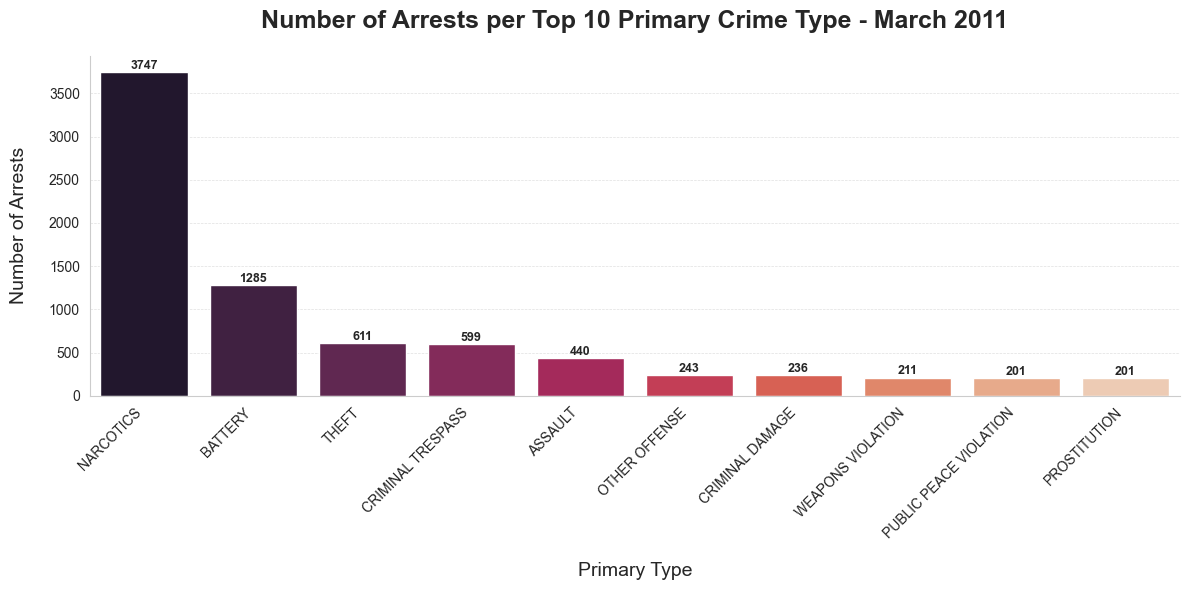

In [ ]:
# -------------------------------------------
# 🔹 FOR 2011: MONTH WITH HIGHEST ARREST RATE 
# -------------------------------------------
# Filter only year 2011 and creating a DF for 2011
chicago_crime_2011_df = chicago_crime_2008_to_2012_df[chicago_crime_2008_to_2012_df['Year'] == 2011]

# Calculating arrest rate per month
arrest_rate_2011 = chicago_crime_2011_df.groupby('Month')['Arrest'].mean()

# Find the month with the highest arrest percentage
highest_month_2011 = arrest_rate_2011.idxmax()
highest_rate_2011 = arrest_rate_2011.max()*100

# Print result 
print(f'In 2011, {highest_month_2011} had the highest arrest percentage at around {round(highest_rate_2011, 2)}%')


# Filter the 2011 DF for the month with the highest arrest rate (which we have previously seen is March)
chicago_crime_highest_month_2011 = chicago_crime_2011_df[chicago_crime_2011_df['Month'] == highest_month_2011]

# Only consider crimes that led to an arrest
arrests_by_type_highest_month_2011 = (
    chicago_crime_highest_month_2011[chicago_crime_highest_month_2011['Arrest'] == True]
    .groupby('Primary Type')
    .size()
)

# Primary type with the highest number of arrests
top_crime_type_highest_month_2011 = arrests_by_type_highest_month_2011.idxmax()
top_arrest_count_highest_month_2011 = arrests_by_type_highest_month_2011.max()

print(f'In {highest_month_2011}, the crime type with the highest number of arrests was {top_crime_type_highest_month_2011}, with {top_arrest_count_highest_month_2011} arrests.')



# Counts arrest per 'Primary Type' (all types, not just the top crime)
top_10_arrests_by_type_highest_month_2011 = (
    chicago_crime_highest_month_2011[chicago_crime_highest_month_2011['Arrest'] == True]
    .groupby('Primary Type')
    .size()
    .sort_values(ascending=False)
    .reset_index(name='Number of Arrests')
    .head(10)
)

# -------------------------------------------
# 🔹 PLOT: NUMBER OF ARRESTS IN MARCH 2011 
# -------------------------------------------
sns.set_style('whitegrid')

plt.figure(figsize=(12,6))

sns.barplot(
    data=top_10_arrests_by_type_highest_month_2011,
    x='Primary Type',
    y='Number of Arrests',
    palette='rocket'
)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Labels above bars
for i, row in top_10_arrests_by_type_highest_month_2011.iterrows():
    plt.text(
        i, row['Number of Arrests'] + 2,    # small offset above the bars
        f'{row['Number of Arrests']}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

# Style improvements
plt.title(f'Number of Arrests per Top 10 Primary Crime Type - {highest_month_2011} 2011', size=18, pad=20, fontweight='bold')
plt.ylabel('Number of Arrests', size=14, labelpad=15)
plt.xlabel('Primary Type', size=14, labelpad=15)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

sns.despine(top=True, right=True, bottom=False, left=False)

plt.tight_layout()
plt.show()


----

## Grand Theft Auto

- Are there certain periods of the year/month/day/time of day where GTA is more frequent?

In [ ]:
# -------------------------------------------
# 🔹 MOTOR VEHICLE THEFT 
# -------------------------------------------
# Filter only MOTOR VEHICLE THEFT
vehicle_thefts_df = (chicago_crime_2008_to_2012_df[
    chicago_crime_2008_to_2012_df['Primary Type'] == 'MOTOR VEHICLE THEFT']).reset_index(drop=True)

# Theft frequency by YEAR
gta_by_year = vehicle_thefts_df.groupby('Year').size()
# print(gta_by_year.sort_values(ascending=False))

# Theft frequency by MONTH
month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December']

gta_by_month = vehicle_thefts_df.groupby('Month').size().reindex(month_order)
# print(gta_by_month.sort_values(ascending=False))

# Theft frequency by WEEKDAY
weekday_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday']

gta_by_weekday = vehicle_thefts_df.groupby('Weekday').size().reindex(weekday_order)
# print(gta_by_weekday.sort_values(ascending=False))

# Theft frequency by TIME OF DAY / HOUR
gta_by_hour = vehicle_thefts_df.groupby('Hour').size()
# print(gta_by_hour.sort_values(ascending=False))

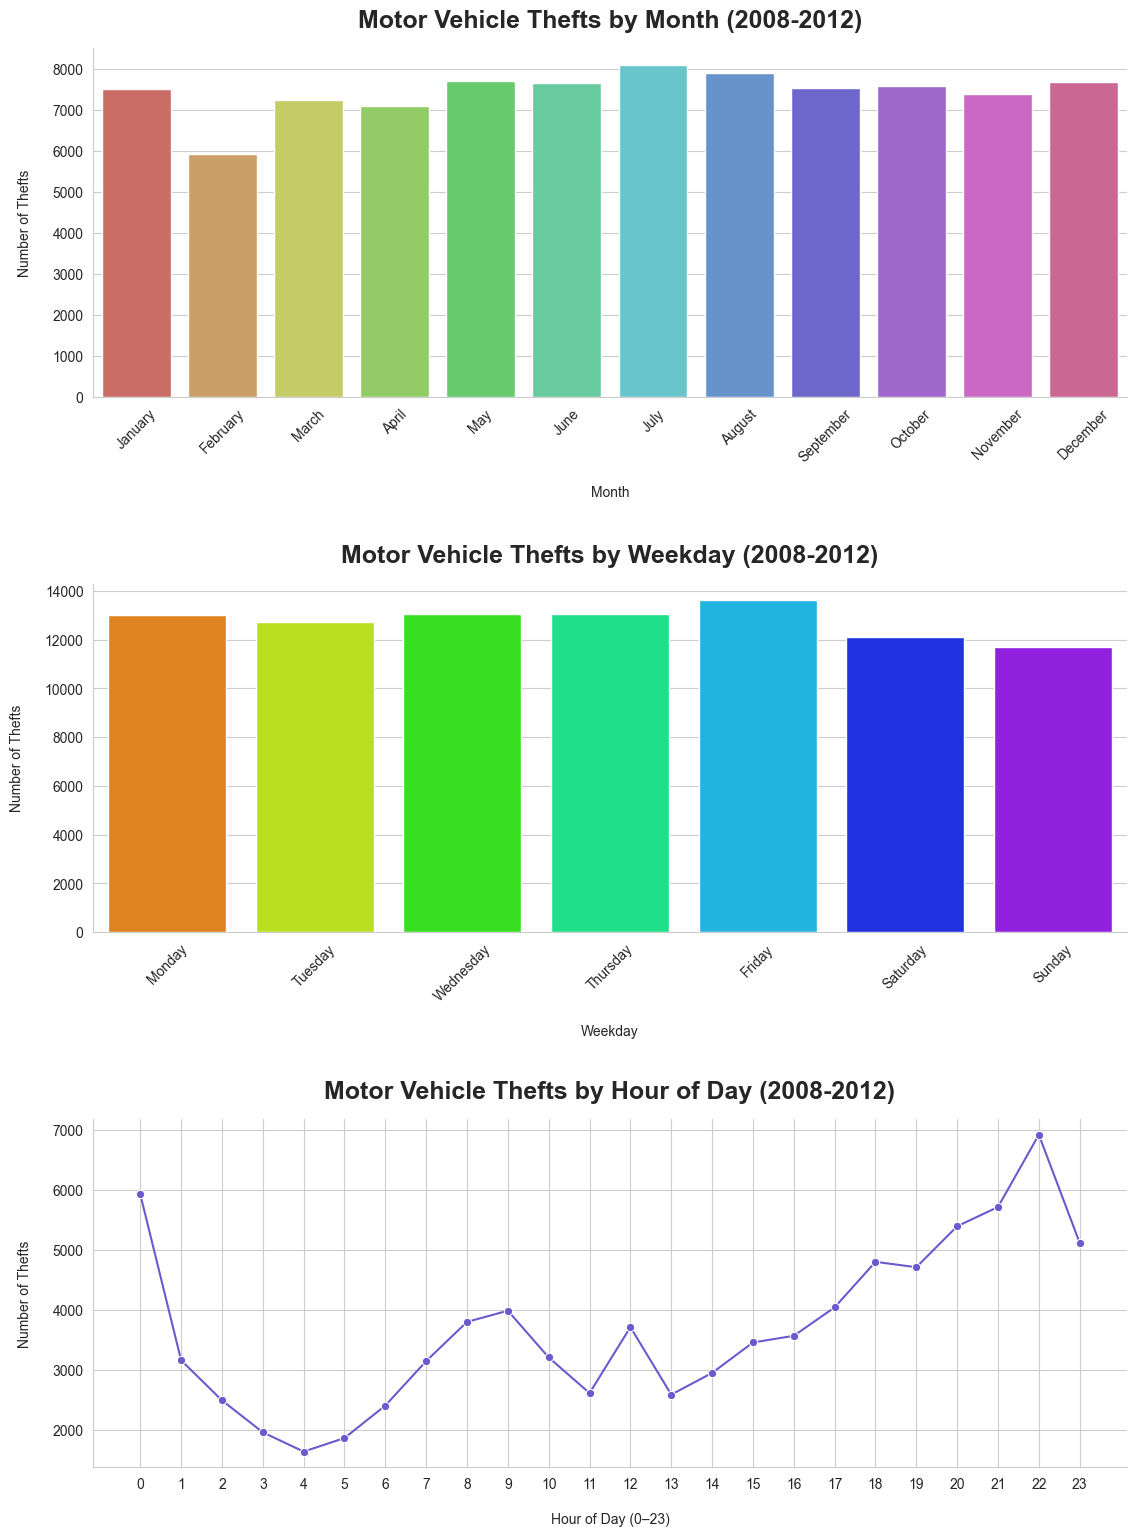

In [16]:
# -------------------------------------------
# 🔹 PLOT: DASHBORD OF VEHICLE THEFTS DATA
# -------------------------------------------
# Consistent style
sns.set_style('whitegrid')

fig, axes = plt.subplots(3, 1, figsize=(12, 16))

sns.despine(top=True, right=True)

# --- MONTH ---
sns.barplot(    
    x=gta_by_month.index,
    y=gta_by_month.values,
    palette='hls',
    ax=axes[0]
)
axes[0].set_title('Motor Vehicle Thefts by Month (2008-2012)', pad=15, fontweight='bold', fontsize=18)
axes[0].set_xlabel('Month', labelpad=15)
axes[0].set_ylabel('Number of Thefts', labelpad=15)
axes[0].tick_params(axis='x', rotation=45)


# --- WEEKDAY ---
sns.barplot(
    x=gta_by_weekday.index,
    y=gta_by_weekday.values,
    palette='gist_rainbow',
    ax=axes[1]
)

axes[1].set_title('Motor Vehicle Thefts by Weekday (2008-2012)', pad=15, fontweight='bold', fontsize=18)
axes[1].set_xlabel('Weekday', labelpad=15)
axes[1].set_ylabel('Number of Thefts', labelpad=15)
axes[1].tick_params(axis='x', rotation=45)


# --- HOUR ---
sns.lineplot(              
    x=gta_by_hour.index,
    y=gta_by_hour.values,
    marker='o',
    ax=axes[2],
    color='slateblue'
)

axes[2].set_title('Motor Vehicle Thefts by Hour of Day (2008-2012)', pad=15, fontweight='bold', fontsize=18)
axes[2].set_xlabel('Hour of Day (0–23)', labelpad=15)
axes[2].set_ylabel('Number of Thefts', labelpad=15)
axes[2].set_xticks(range(0,24))
axes[2].tick_params(axis='x')


plt.tight_layout(pad=3)
plt.show()

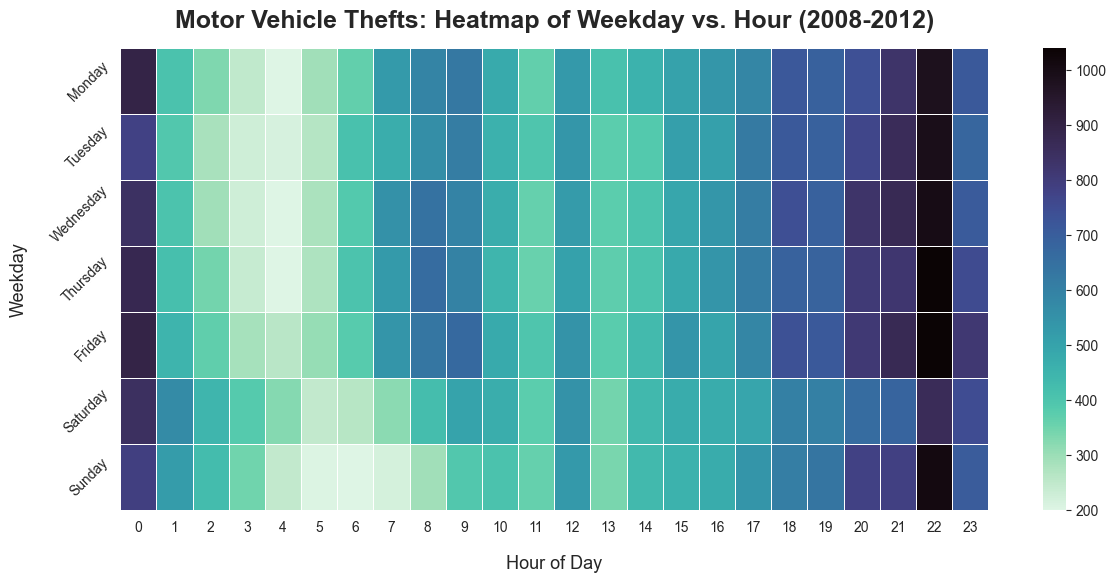

In [31]:
# -------------------------------------------
# 🔹 PLOT: GTA - HEATMAP OF DAY VS. HOUR
# -------------------------------------------
heatmap_data = vehicle_thefts_df.pivot_table(
    index='Weekday',
    columns='Hour',
    values='ID',        # any column works here, since it's just used to count the number of rows
    aggfunc='count'
).reindex(weekday_order)

# Plot
plt.figure(figsize=(14,6))

sns.heatmap(
    heatmap_data,
    cmap='mako_r',
    linewidths=.5
)

# Style improvements
plt.title('Motor Vehicle Thefts: Heatmap of Weekday vs. Hour (2008-2012)', pad=15, fontweight='bold', fontsize=18)
plt.xlabel('Hour of Day', labelpad=15, fontsize=13)
plt.ylabel('Weekday', labelpad=15, fontsize=13)
plt.yticks(rotation=45)

plt.show()


#### Analysis 

**Year**

While there is a difference in the number of vehicle thefts between each year, I think 'years' might be too broad to draw any conclusions. I thought 2008 and 2009 were going to have a higher number of thefts since there was an economic crisis then (and an unstable economy tends to lead to higher rates of crime) - but 2009 had the lowest amount of vehicle thefts. 


**Month**

When looking at months, we can start to see that July and August are the top 2 months for GTA (possibly because people tend to be on vacation during the summer and might leave their car parked/unattended for a longer period of time than usual). Although overall, the numbers aren't hugely different month to month. The only month that really stands out is February, which seems to be the "safest" month for cars (in terms of GTA). 


**Day**

Just like we say in 8.1, Fridays are the riskiest day to leave your care unattended. Overall, there appears to be a slight increase in vehicle thefts towards the end of the week, but ***not*** on weekends (Saturday and Sunday are apparently the "safest" days). 


**Hour / Time of day**

The time of day definitely seems to be the best indicator of when vehicle thefts occur. Based on the data, 10 pm is the most likely time of day for GTA. The top five hours are 8 pm to 12 am. The citizens of Chicago don't seem to be "morning people" as 2 to 6 am are the "safest" hours of the day for cars. 


**Dashboard plots**

I mostly did these for fun, but they do provide a pretty good overview. You can visually see the month of the year, and weekday doesn't really matter (unless it's February). The "Hour of Day" plot does provide a very good overview of how the vehicle thefts dip in the early morning hours, only to rise during the day, and hit a peak at 10 pm. 


**Heatmap**

The heatmap shows that, once again, the day of the week doesn't really matter (although Friday is *slightly* more risky). What it does show is that nighttime (especially around 10 pm and 12 am) is where most vehicle thefts occur. 


**Conclusion**

Don't leave your vehicle unattended during the night. 

---

## Prostiturion on Friday Nights

- Are there any (geographical) areas hit particularly hard by prostitution on friday nights?

- Can you vizualise the locations from 9.1 on a map of Chicago? Is there a concentration somewhere?

In [ ]:
# -------------------------------------------
# 🔹 PROSTITUTION DATA - FRIDAY NIGHTS
# -------------------------------------------
# Filer to 'PROSTITUTION' crimes 
prostitution_df = chicago_crime_2008_to_2012_df[
    chicago_crime_2008_to_2012_df['Primary Type'] == 'PROSTITUTION'
]

# Filter to 'Fridays'
prostitution_fridays = prostitution_df[
    prostitution_df['Weekday'] == 'Friday'
]

# Filter to night 
# According to Google, "a common understanding is that night starts at around 9 pm and ends around 4 am" 
prostitution_friday_night = prostitution_fridays[
    (prostitution_fridays['Hour'] >= 21) | (prostitution_fridays['Hour'] <= 4)
]

# Count by 'Community Area'
prostitution_area_counts = (
    prostitution_friday_night
    .groupby('Community Area')
    .size()
    .sort_values(ascending=False)
)


# -------------------------------------------
# 🔹 PLOT: MAP OF CHICAGO WITH
# -------------------------------------------
# Center of Chicago
chicago_center = [41.8781, -87.6298]

# Base map 
m = folium.Map(
    location=chicago_center, 
    zoom_start=11, 
    tiles="CartoDB positron",
    attr="© OpenStreetMap contributors © CARTO"
)

# Heatmap of all Friday-night prostitution incidents
coords = prostitution_friday_night[['Latitude','Longitude']].dropna()
HeatMap(coords.values.tolist(), radius=12).add_to(m)

# Highlight top 5 Community Areas
top_5_areas = (
    prostitution_friday_night
    .groupby('Community Area')
    .size()
    .sort_values(ascending=False)
    .head()
)

for area in top_5_areas.index:
    # Get mean coordinates of incidents in this area
    area_coords = prostitution_friday_night[prostitution_friday_night['Community Area'] == area][['Latitude','Longitude']].dropna()
    mean_lat = area_coords['Latitude'].mean()
    mean_lon = area_coords['Longitude'].mean()

    folium.Marker(
        location=[mean_lat, mean_lon],
        popup=f"Community Area {int(area)}: {top_5_areas[area]} incidents",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

m.save('prostitution_friday_night_map.html')    
# this refused to load in Jupyter Notebook so I had to save it as a HTML file instead 
# which can be opened in a browser of your choice 


**Recommendation: View the map (the HTML file) at the same time as reading this!**

**Top 5 areas hit especially hard by prostitution on Friday night:**

1. Community Area 25 (142 incidents): North-west of West Garfield Park 

2. Community Area 68 (83 incidents): South-east of West Englewood

3. Community Area 8 (74 incidents): Near North Side

4. Community Area 26 (72 incidents): West Garfield park

5. Community Area 23 (69 incidents): Humboldt Park

While there are some areas where prostitution incidents appear to be more concentrated, overall, it appears to be pretty spread out in most of the city. With the heatmap, you can see that the area near West Garfield Park (Community Area 26)  seems to be the most concentrated (it's the only part of the map that shows some orange/red colour). If you look at the centre of Chicago (Community Area 8), the North Side is definitely more affected than the South Side. 

It does seem like prostitution is a problem in many places in Chicago.

----

## Socioeconomic Aspect 

- Are there certain kinds of socoeconomic area that are more prone to certain kinds of crimes? Do a deep dive in the direction you fancy yourself here.


In [ ]:
# -------------------------------------------
# 🔹 MERGING CRIME DF AND CENSUS DF
# -------------------------------------------

# After looking at the two sets of data, the column **Community Area** (in Crime DF), 
# and **Community Area Number** (in Census DF) identifies the same thing. 
# So I'm going to be merging the datasets on that

# Merging the datasets (& removing the duplicated column)
merged_df = pd.merge(
    chicago_crime_2008_to_2012_df,
    chicago_census_2008_to_2012_df,
    left_on='Community Area',
    right_on='Community Area Number',
    how='left'
).drop(columns=['Community Area Number'])


# Strip whitespace ("PER CAPITA INCOME " has a trailing space)
merged_df.columns = merged_df.columns.str.strip()  # remove leading/trailing spaces


# Compute average indicators for each primary crime type
crime_socio_summary = merged_df.groupby('Primary Type')[
    ['PERCENT HOUSEHOLDS BELOW POVERTY',
     'PERCENT AGED 16+ UNEMPLOYED',
     'PER CAPITA INCOME',
     'HARDSHIP INDEX',
     'PERCENT OF HOUSING CROWDED',
     'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA']
].mean().sort_values('HARDSHIP INDEX', ascending=False)


# Define high hardship threshold as median
hardship_threshold = merged_df['HARDSHIP INDEX'].median()

# Label each row as 'High' or 'Low' hardship
merged_df['High Hardship'] = merged_df['HARDSHIP INDEX'] > hardship_threshold

# Count crime types in high vs. low hardship areas 
crime_by_hardship = merged_df.groupby(['Primary Type', 'High Hardship']).size().unstack(fill_value=0)

# Compute percentage of each crime occurring in high hardship areas
crime_by_hardship['High Hardship (%)'] = crime_by_hardship[True] / (crime_by_hardship[True] + crime_by_hardship[False]) * 100

# Sort by High Hardship (%) for visualisation (visualisation is in the next cell)
crime_by_hardship_sorted = crime_by_hardship.sort_values('High Hardship (%)', ascending=False)


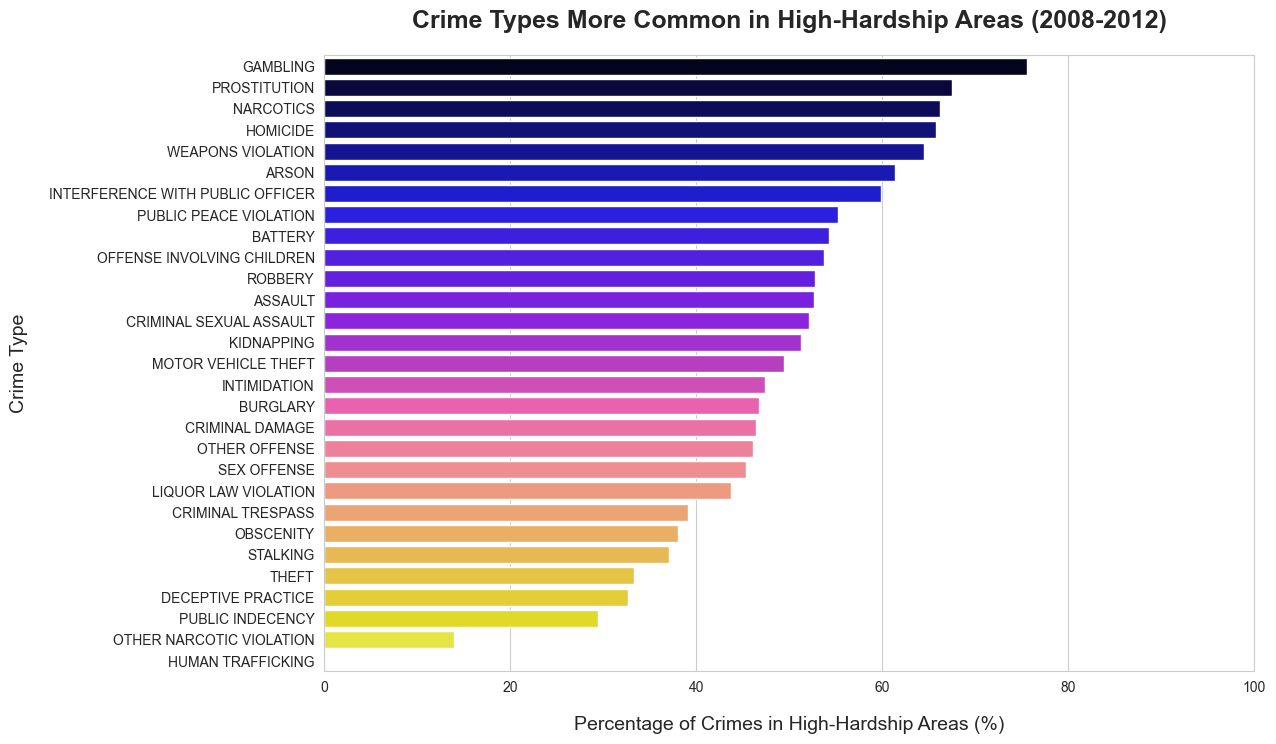

In [32]:
# -------------------------------------------
# 🔹 PLOT: CRIMES IN HIGH-HARDSHIP AREAS
# -------------------------------------------
plt.figure(figsize=(12,8))

sns.barplot(
    x='High Hardship (%)',
    y=crime_by_hardship_sorted.index,
    data=crime_by_hardship_sorted,
    palette='gnuplot2'
)

# Style improvements
plt.title('Crime Types More Common in High-Hardship Areas (2008-2012)', size=18, pad=20, fontweight='bold')
plt.xlabel('Percentage of Crimes in High-Hardship Areas (%)', size=14, labelpad=15)
plt.ylabel('Crime Type', size=14, labelpad=15)
plt.xlim(0, 100)

plt.show()

In [30]:
# -------------------------------------------
# 🔹 PLOT: MAP - HARDSHIP & CRIME HEATMAPS
# -------------------------------------------

# The crime types for this plot/map have been selected based on the top 5 most recorded crimes in Chicago, 
# and the top 5 crimes affecting high-hardship areas the most 
# (narcotics appeard on both lists, so in there are 9 types in total)


# Load community area shapes
community_areas = gpd.read_file("https://data.cityofchicago.org/resource/igwz-8jzy.geojson")

# Ensure numeric join key
community_areas['area_num_1'] = community_areas['area_num_1'].astype(int)


# Merge hardship index into shapes
community_areas = community_areas.merge(
    chicago_census_2008_to_2012_df[['Community Area Number', 'HARDSHIP INDEX']],
    left_on='area_num_1',
    right_on='Community Area Number',
    how='left'
)


# Filer crime data to only selected types
crime_types = [
    "THEFT", "BATTERY", "CRIMINAL DAMAGE", "NARCOTICS", "BURGLARY",
    "GAMBLING", "PROSTITUTION", "HOMICIDE", "WEAPONS VIOLATION"
]

crime_subset = chicago_crime_2008_to_2012_df[
    chicago_crime_2008_to_2012_df['Primary Type'].isin(crime_types)
].dropna(subset=['Latitude', 'Longitude'])


# Create map centered on Chicago
m = folium.Map(
    location=[41.8781, -87.6298], 
    zoom_start=11, 
    tiles="cartodbpositron",
    attr="© OpenStreetMap contributors"
)


# Add hardship choropleth (base layer)
folium.Choropleth(
    geo_data=community_areas.to_json(),
    data=community_areas,
    columns=['area_num_1', 'HARDSHIP INDEX'],
    key_on='feature.properties.area_num_1',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.4,
    legend_name='Hardship Index',
    name='Hardship Index (base layer)',
    overlay=True,
    control=False  # always visable
).add_to(m)


# Add one layer per crime
for c in crime_types:
    layer = folium.FeatureGroup(name=c, show=False)

    df = crime_subset[crime_subset['Primary Type'] == c]

    heat_data = df[['Latitude', 'Longitude']].values.tolist()

    HeatMap(
        heat_data, 
        radius=10, 
        blur=15,
        max_zoom=1,
        min_opacity=0.6,
    ).add_to(layer)

    layer.add_to(m)


# Add layer controls
folium.LayerControl(collapsed=False).add_to(m)


# Save map
m.save("chicago_crime_hardship_layers.html")

I decided to look at crimes in relation to the 'HARDSHIP INDEX'. The percentages used in the first figure aren't reflecting raw crime numbers - they reflect **where** those crimes occur relative to hardship. 

The visualisation shows us which types of crime tend to occur in higher hardship socioeconomic areas (i.e. areas with more poverty, lower income, higher unemployment rates, lower educational attainment, more crowded housing, etc.). 

In the figure, we can see that the top five entries are:
- Gambling
- Prostitution
- Narcotics
- Homicide
- Weapons violation

When reading about the topic, I found that a very common mistake people make when discussing hardship is thinking/saying that hardship is the *"cause"*. Hardship is a ***context variable***, and not a "cause". The barplot and map are **not** showing us that "poor areas cause more narcotics crimes" or "lower education levels cause homicides". Instead, the plot and map show us that certain types of crimes are ***more frequently recorded*** in the areas already facing more socioeconomic challenges, while other crimes are more widespread and don't appear to be influenced by hardship.

To circle back to the original question: *“Are there certain kinds of socioeconomic areas that are more prone to certain kinds of crimes?”*

Yes. We can clearly see that high-hardship areas show elevated levels of: 
- Narcotics-related crimes
- Prostitution
- Illegal gambling
- Weapons offenses
- Homicide

Which tells us that crimes associated with underground economies, violence, and social instability are disproportionately concentrated in communities facing socioeconomic challenges.

----